# Spectral Analysis of Irregular Time Series

**Problem:** You have measurements taken at non-uniform times and want to find periodic signals.

This is common in astronomy (observations at irregular intervals), finance (trading data), and any sensor system where sampling isn't perfectly regular.

## Setup

First, install nufftax if running on Colab:

In [ ]:
# Uncomment the following lines to install nufftax on Colab
# !pip install uv
# !uv pip install nufftax --system

In [2]:
import jax.numpy as jnp
import numpy as np
from nufftax import nufft1d1
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Generate Irregularly Sampled Signal

We create a signal with two known frequencies (1.2 Hz and 3.5 Hz) sampled at irregular times.

In [3]:
# Signal parameters
n_obs = 100          # Number of samples
T_total = 10.0       # Total observation time (seconds)
freq1, freq2 = 1.2, 3.5  # True frequencies (Hz)

# Generate irregular observation times
np.random.seed(42)
t_obs = np.sort(np.random.uniform(0, T_total, n_obs))

# True signal: sum of two sinusoids + noise
signal = np.sin(2 * np.pi * freq1 * t_obs) + 0.6 * np.sin(2 * np.pi * freq2 * t_obs)
signal += 0.1 * np.random.randn(n_obs)

print(f"Generated {n_obs} samples over {T_total} seconds")
print(f"True frequencies: {freq1} Hz and {freq2} Hz")

Generated 100 samples over 10.0 seconds
True frequencies: 1.2 Hz and 3.5 Hz


## Compute Spectrum Using NUFFT

The key step is to properly scale the observation times to $[-\pi, \pi)$.

In [4]:
# KEY: Scale times to [-pi, pi) with proper normalization
# x = 2*pi * t / T - pi  (maps [0, T] to [-pi, pi])
t_scaled = 2 * np.pi * t_obs / T_total - np.pi

# Compute spectrum using NUFFT Type 1
c = jnp.array(signal, dtype=jnp.complex64)
t_jax = jnp.array(t_scaled, dtype=jnp.float32)

n_modes = 256
spectrum = nufft1d1(t_jax, c, n_modes=n_modes, eps=1e-6)
power = jnp.abs(spectrum) ** 2

# Frequency axis: k / T gives physical frequency in Hz
k = np.arange(n_modes) - n_modes // 2
freq_axis = k / T_total  # Hz

## Analyze Results

In [5]:
# Find peaks in positive frequencies
positive_mask = freq_axis > 0
positive_freqs = freq_axis[positive_mask]
positive_power = np.array(power)[positive_mask]

# Use a higher threshold to filter out noise peaks
peaks, properties = find_peaks(positive_power, height=np.max(positive_power) * 0.3)
detected_freqs = positive_freqs[peaks]

print("Detected frequencies:")
for f in detected_freqs:
    print(f"  {f:.2f} Hz")
print(f"\nTrue frequencies: {freq1} Hz and {freq2} Hz")

Detected frequencies:
  1.20 Hz
  3.50 Hz

True frequencies: 1.2 Hz and 3.5 Hz


## Visualization

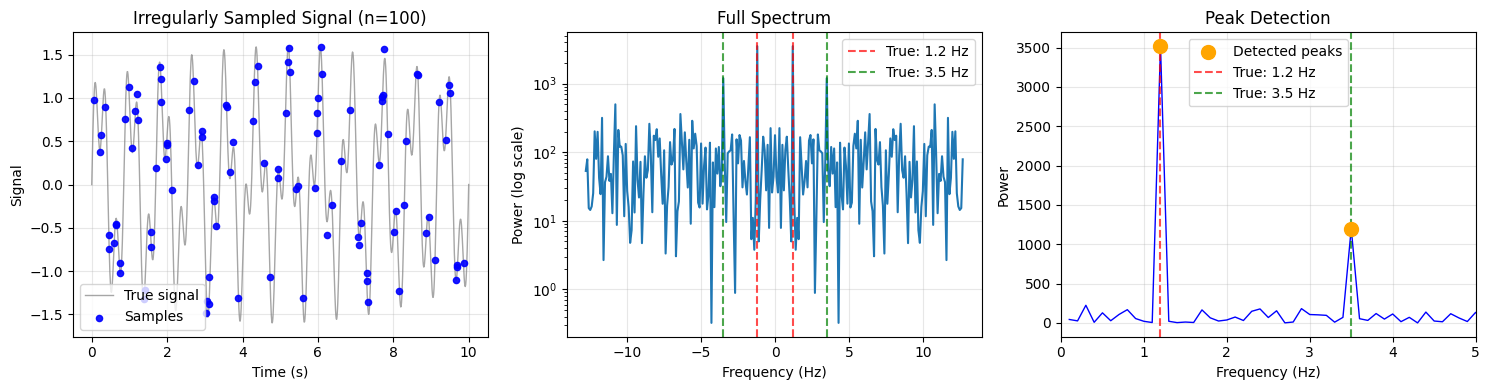

In [6]:
# Plotting code (click to expand)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Signal with original continuous signal
ax = axes[0]
# Plot the true underlying signal (without noise)
t_fine = np.linspace(0, T_total, 1000)
signal_true = np.sin(2 * np.pi * freq1 * t_fine) + 0.6 * np.sin(2 * np.pi * freq2 * t_fine)
ax.plot(t_fine, signal_true, 'gray', linewidth=1, alpha=0.7, label='True signal')
ax.scatter(t_obs, signal, s=20, alpha=0.9, c='blue', zorder=5, label='Samples')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal')
ax.set_title(f'Irregularly Sampled Signal (n={n_obs})')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Full spectrum
ax = axes[1]
ax.semilogy(freq_axis, np.array(power))
ax.axvline(freq1, color='r', linestyle='--', alpha=0.7, label=f'True: {freq1} Hz')
ax.axvline(-freq1, color='r', linestyle='--', alpha=0.7)
ax.axvline(freq2, color='g', linestyle='--', alpha=0.7, label=f'True: {freq2} Hz')
ax.axvline(-freq2, color='g', linestyle='--', alpha=0.7)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (log scale)')
ax.set_title('Full Spectrum')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Positive frequencies with detected peaks
ax = axes[2]
ax.plot(positive_freqs, positive_power, 'b-', linewidth=1)
ax.scatter(detected_freqs, positive_power[peaks], c='orange', s=100, 
           marker='o', zorder=5, label='Detected peaks')
ax.axvline(freq1, color='r', linestyle='--', alpha=0.7, label=f'True: {freq1} Hz')
ax.axvline(freq2, color='g', linestyle='--', alpha=0.7, label=f'True: {freq2} Hz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Peak Detection')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 5)

plt.tight_layout()
plt.show()